<a href="https://colab.research.google.com/github/northpr/tensorflow-resources/blob/main/udemy_tensorflow_course/10_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with Tensorflow
**Project:** BitPredict 💰 Using TensorFlow to predict the price of Bitcoin based on the historical price of BitCoin

**Note:** This is not financial advice. Just to learn how to adapt deep learning to predict time series

**Resource:** 
- https://otexts.com/fpp3/a-tidy-forecasting-workflow.html

## Preparation:

### Get the data and prepare

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-10-02 00:10:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2022-10-02 00:10:37 (65.6 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
import pandas as pd

df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


## Inspect the data 👀

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [ ]:
print(f"Number of samples we have: {len(df)}")

Number of samples we have: 2787


**🔑 Quick Note**

The data we have of the historical price of Bitcoin for the past 8 years are only 2787 samples.

Typically deep learning models usually like lots and lots of samples.

A small number of samples is something you'll often run into with time series data problems.

In [ ]:
# Only wawnt closing price for each day
bitcoin_prices = bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


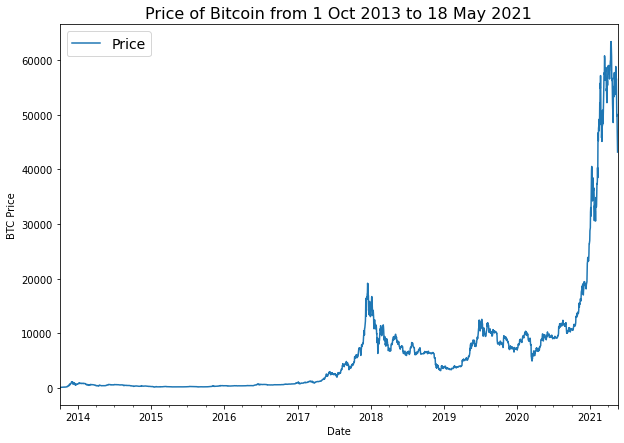

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

## Create train and test datasets

In [ ]:
# Check the first 5
bitcoin_prices.iloc[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

**Note❗️**

We can't do normal split because we're focusing on time series predict so we need to do time-series split.

Resource: [Scikit-learn, Time-Series split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

In [ ]:
# Create train and test splits
split_size = int(0.8* len(prices))

x_train, y_train = timesteps[:split_size], prices[:split_size]

x_test, y_test = timesteps[split_size:], prices[split_size:]

### Scatter plot function 

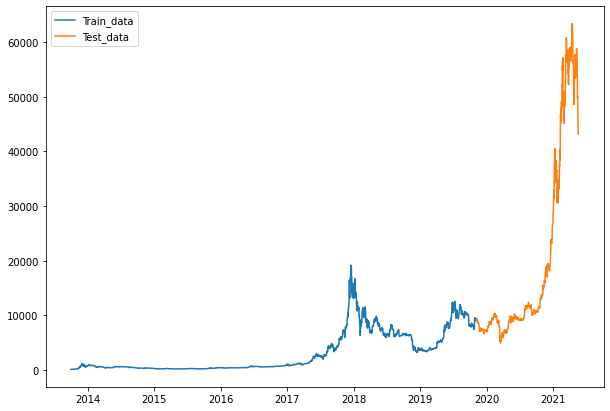

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(x_train, y_train, label='Train_data')
plt.plot(x_test, y_test, label='Test_data')
plt.legend()

In [ ]:
# Plot the split
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

  # plt.scatter(x_train, y_train, s=5, label="train_data")
  # plt.scatter(x_test, y_test, s=5, label="test_data")
  # plt.xlabel("Days")
  # plt.ylabel("BTC Price")
  # plt.legend(fontsize=14)
  # plt.show()  

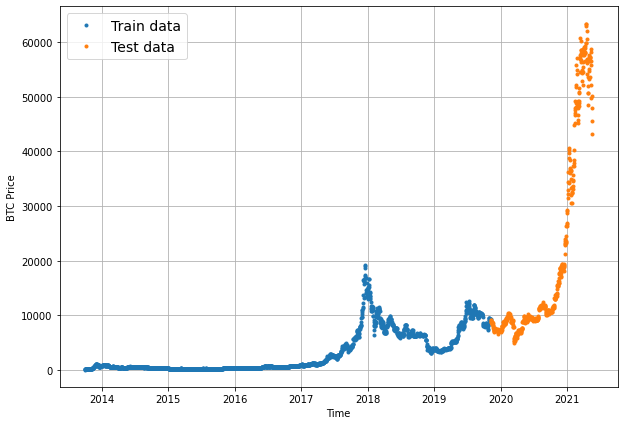

In [ ]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_train, values=y_train, label="Train data")
plot_time_series(timesteps=x_test, values=y_test, label="Test data")

# Modeling Experiments

Experiments Model We will create.
- Model 0: Naive model (baseline)
- Model 1: Dense Model
- Model 2: Same as model 1
- Model 3: Same as model 1
- Model 4: Conv1D
- Model 5: LSTM
- Model 6: Same as model 1 (but with multivariate data)
- Model 7: N-BEATS algorithm
- Model 8: Ensemble (multiple models stacked together)
- Model 9: Future prediction model
- Model 10: Same as model 1 (but with turkey data introduced)


## Model 0: Naive Forecast (baseline)

The formula looks like: $$\hat{y}_{t} = y_{t-1}$$

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - **this is for horizon of 1**

In [ ]:
# Create a naive forecast
naive_forecast = y_test[0:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
len(x_test), len(naive_forecast)

(558, 557)

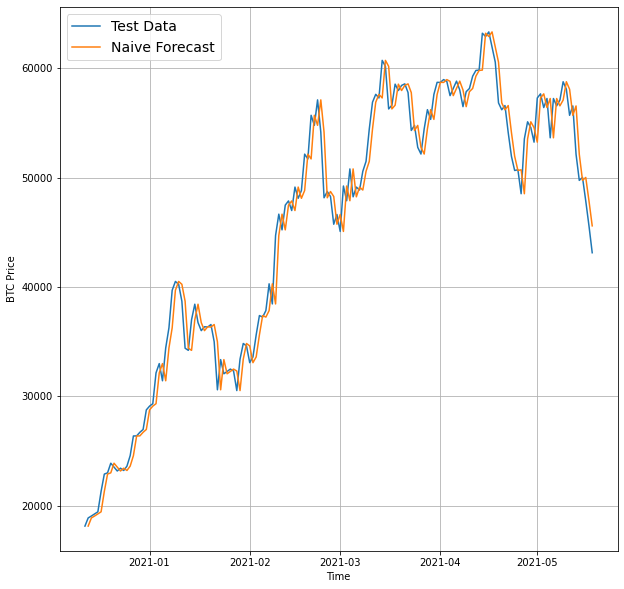

In [ ]:
# Plot native forecast
plt.figure(figsize=(10,10))
# plot_time_series(timesteps=x_train, values=y_train, start=300, label="Train Data")
plot_time_series(timesteps=x_test, values=y_test, start=400, format="-", label="Test Data")
plot_time_series(timesteps=x_test[1:], values=naive_forecast, start=400, format="-", label="Naive Forecast")

### Evaluating a time series model 🧮 

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression metrics.

In [ ]:
import tensorflow as tf

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (Focus on Non-Seasonal predict)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season


Test MASE (this very should = 1 or be very close to 1 with naive forecast)


In [ ]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

## Create evaluate function.

Create a function to take in model predictions and truth values then return evaluation.


In [ ]:
def evaluate_preds(y_true, y_pred):
  # ❗️ Make sure float32 datatype (for metric calculations) sometime it stuck in datatype problems
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evalution metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse,0.5)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy(),}

Checking the function is work.

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                         y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

# Format Data Part 2: Windowing our dataset

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```


In [ ]:
# Setup global variables for windiw and horizon size
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create function to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.
  E.g. if horizon =1
  Input: [0, 1, 2, 3, 4, 5, 6] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Randomly Test ❌
print(tf.range(8)+1)
print(tf.expand_dims(tf.range(8)+1, axis=0))

# tf.expand_dims: https://www.tensorflow.org/api_docs/python/tf/expand_dims

tf.Tensor([1 2 3 4 5 6 7 8], shape=(8,), dtype=int32)
tf.Tensor([[1 2 3 4 5 6 7 8]], shape=(1, 8), dtype=int32)


In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

In [ ]:
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [ ]:
btc_price = bitcoin_prices['Price'].to_numpy()
btc_price[:20]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
       126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
       152.55183, 160.33883])

We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quiet slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use Numpy indexing to create a 2D array of multiple windows steps, for example:
```
[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8],.....
```

3. Uses the 2D array of multiple window steps (from 2.) to index a target series (e.g. the historical price of Bitcoin)
4. Use our `get_labelled_window()` function we created above to turn the window steps into windows with a specified horizon

In [ ]:
test = btc_price.tolist() # Change btc_price to list

In [ ]:
import numpy as np

# Create function to view NumPy array as windows
def make_windows(x, windows_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(windows_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(windows_size+horizon-1)),axis=0).T # create 2D array of window size and last block is to prevent go out of range
  # print(f"Window indexes:\n {window_indexes}, \n\nWindow indexes shape: {window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D arra of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)
  return windows, labels



In [ ]:
# Test
full_windows, full_labels = make_windows(prices)
print(f"Full windows: \n{full_windows[0:10]} \n\nFull labels: \n{full_labels[0:10]}")
print("\n=======")
print(f"\nShape of full windows: {full_windows.shape}\nShape of full labels:{full_labels.shape}")

Full windows: 
[[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]
 [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]
 [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116]
 [121.33866 120.65533 121.795   123.033   124.049   125.96116 125.27966]
 [120.65533 121.795   123.033   124.049   125.96116 125.27966 125.9275 ]
 [121.795   123.033   124.049   125.96116 125.27966 125.9275  126.38333]
 [123.033   124.049   125.96116 125.27966 125.9275  126.38333 135.24199]
 [124.049   125.96116 125.27966 125.9275  126.38333 135.24199 133.20333]
 [125.96116 125.27966 125.9275  126.38333 135.24199 133.20333 142.76333]] 

Full labels: 
[[123.033  ]
 [124.049  ]
 [125.96116]
 [125.27966]
 [125.9275 ]
 [126.38333]
 [135.24199]
 [133.20333]
 [142.76333]
 [137.92333]]


Shape of full windows: (2780, 7)
Shape of full labels:(2780, 1)


In [ ]:
# Visualize the first 3 windows/labels
print("The first 3 windows/labels")
for i in range(3):
  print(f"Window: {full_windows[i]}  ->  Label: {full_labels[i]}\n")
print("=======")
print("\nThe last 3 windows/labels")
for i in range(3):
  print(f"Window: {full_windows[i-3]}  ->  Label: {full_labels[i-3]}")

The first 3 windows/labels
Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]  ->  Label: [123.033]

Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]  ->  Label: [124.049]

Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]  ->  Label: [125.96116]


The last 3 windows/labels
Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676]  ->  Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472]  ->  Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361]  ->  Label: [43144.47129086]


🔑 **Note:** There's a function which does similar, Check this link: [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array)

# Turning windows into training and test sets

In [ ]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will make train to 80%
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels


In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(full_windows), len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2780, 2224, 556, 2224, 556)

In [ ]:
train_windows.shape, train_labels.shape

((2224, 7), (2224, 1))

In [ ]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

# Make a modelling checkpoint 📍

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More speicfically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs) , we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following:
[Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)



In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename.
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # Only output a limited amount of text
                                            save_best_only=True)

# Continue creating a model

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs - because the number of the data is small

In [ ]:
len(train_windows[0])

7

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# # 1. Construct model ---Only Test---
# inputs = layers.Input(shape=len(train_windows[0]))
# x = layers.Dense(128, activation="relu")(inputs),
# outputs = layers.Dense(HORIZON, activation="linear")(inputs)
# model_1 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_1_dense")

model_1 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation="linear")],
                              name="model_1_dense")

# 2. Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


TypeError: ignored

### Make prediction and evaluate

In [ ]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9752 - mae: 585.9752 - mse: 1197801.2500


[585.9751586914062, 585.9751586914062, 1197801.25]

In [ ]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171744.0000


[568.9510498046875, 568.9510498046875, 1171744.0]

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actial forecasts, they're only pseudo forecasts becaise actia; forecasts are into the future).

1. Take in a train model
2. Take in some inputs data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data,
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
print(f"Shape of model 1 predict: {model_1_preds.shape}, \n\nModel 1 prediction:\n{model_1_preds[:10]}")

Shape of model 1 predict: (556,), 

Model 1 prediction:
[8861.713  8769.888  9015.712  8795.52   8723.8125 8730.111  8691.953
 8502.056  8460.962  8516.548 ]


In [ ]:
model_1_results = evaluate_preds(y_true=test_labels, y_pred=model_1_preds)
model_1_results

{'mae': array([11928.929 , 11795.891 , 11974.977 , 11948.295 , 11954.37  ,
        12005.419 , 12095.949 , 12114.574 , 12074.432 , 12274.319 ,
        12328.178 , 12355.67  , 12659.423 , 12910.017 , 12878.645 ,
        13093.805 , 12949.455 , 13008.3125, 12720.619 , 12814.962 ,
        12581.032 , 12707.599 , 12820.863 , 12856.264 , 12869.688 ,
        12947.94  , 12808.82  , 12728.707 , 12714.619 , 12702.064 ,
        12856.512 , 12927.328 , 12960.66  , 12967.023 , 12928.019 ,
        13054.392 , 13032.358 , 13233.182 , 13509.829 , 12790.82  ,
        13002.82  , 13009.273 , 12891.54  , 12929.485 , 12987.106 ,
        12930.547 , 12948.688 , 12972.473 , 12937.096 , 12872.538 ,
        12818.357 , 12918.381 , 12975.588 , 12979.921 , 13169.249 ,
        12887.851 , 12853.18  , 12845.99  , 12591.284 , 12378.13  ,
        12360.252 , 12528.333 , 12347.6875, 12353.043 , 12309.107 ,
        12329.122 , 11962.128 , 11905.701 , 11974.921 , 11866.165 ,
        11859.349 , 12016.113 , 12007.855

Shape on the upper blog is not the same so it gives different results from what we expected.

In [ ]:
# Shape is not the same so we need to change it
test_labels.shape, model_1_preds.shape
tf.squeeze(test_labels).shape, model_1_preds.shape


(TensorShape([556]), TensorShape([556]))

In [ ]:
# Squeeze the test_labels to make it the same
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 568.9511,
 'mse': 1171744.0,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [ ]:
# Compare with naive_results
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

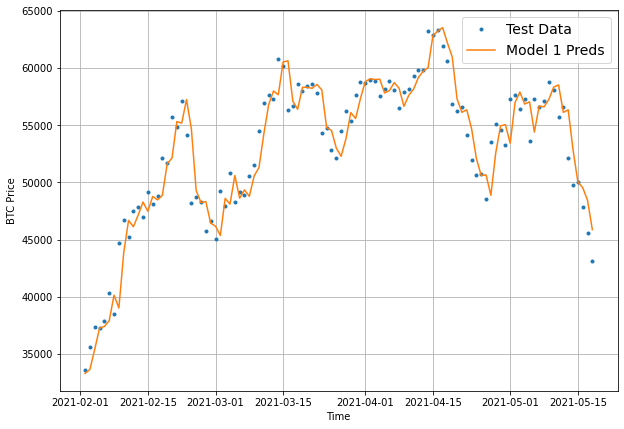

In [ ]:
# Plot model 1 predictions
OFFSET=450
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=OFFSET, label="Test Data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_1_preds, format="-", start=OFFSET, label="Model 1 Preds")

## Model 2: Dense (window = 30, horizon = 1)

In [ ]:
# Set parameters
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in apast

In [ ]:
# Make windows data with appropriate horizon and window sizes
full_windows, full_labels= make_windows(prices, windows_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
train_windows[0:3], train_labels[0:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [ ]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

### Make prediction and evaluate

In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 608.9620


608.9619750976562

In [ ]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9620


608.9619750976562

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [ ]:
#E Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.962,
 'mse': 1281440.6,
 'rmse': 1132.0073,
 'mape': 2.769341,
 'mase': 1.0644715}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mse': 1171744.0,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.99948955}

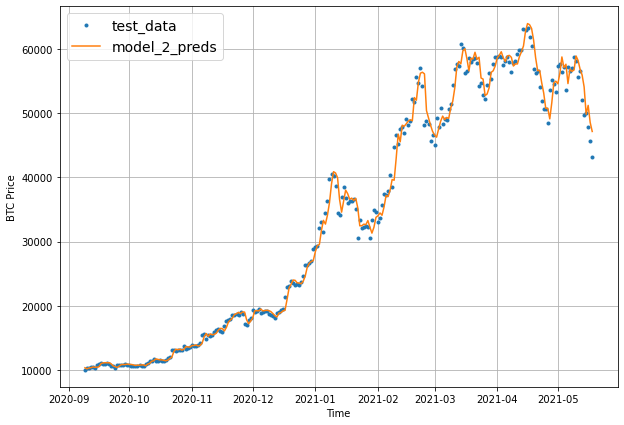

In [ ]:
OFFSET = 300
plt.figure(figsize=(10,7))
# Account for test window offset when plotting
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=OFFSET, label="test_data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_2_preds, start=OFFSET, format="-", label="model_2_preds")

## Model 3: Demse (window = 30, horizon = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, windows_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output)
model_3 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

### Make prediction and evaluate

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1340.4274


1340.4273681640625

In [ ]:
# Load in the best performing model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1234.8838


1234.8837890625

In [ ]:
# Get forecast predictions
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

In [ ]:
model_3_preds.shape, test_labels.shape

(TensorShape([551, 7]), (551, 7))

In [ ]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  561.2253  ,   301.9714  ,   297.9478  ,   413.84305 ,
          445.20926 ,   540.59705 ,   527.2282  ,   441.84564 ,
          498.7735  ,   639.19226 ,   803.132   ,   731.72614 ,
          678.6171  ,   797.1857  ,   575.334   ,   280.21143 ,
          239.92166 ,   246.15207 ,   276.387   ,   285.75482 ,
          118.8042  ,   135.45549 ,   191.11844 ,   251.82582 ,
          170.28934 ,   154.20027 ,   107.24477 ,    97.662735,
          111.26402 ,   139.854   ,   269.1739  ,   369.812   ,
          270.48102 ,   263.1211  ,   247.72252 ,   255.5051  ,
          298.48172 ,   245.26402 ,   243.13094 ,   255.7583  ,
          416.62576 ,   150.97021 ,    94.16588 ,   101.62012 ,
           93.76974 ,    86.75321 ,    73.2793  ,    79.045204,
           89.541084,    93.11977 ,   106.798546,   141.09578 ,
          178.73674 ,   145.46994 ,   256.4566  ,   392.81656 ,
          560.9116  ,   552.8188  ,   536.1548  ,   535.26874 ,
          448.70444 ,   267.2329 

### Make our evaluation function work for larger horizons

In [ ]:
def evaluate_preds(y_true, y_pred):
  # ❗️ Make sure float32 datatype (for metric calculations) sometime it stuck in datatype problems
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evalution metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse,0.5)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    maps = tf.reduce_mean(mase)


  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy(),}

In [ ]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1234.8838,
 'mse': 5393734.0,
 'rmse': 1419.1364,
 'mape': 5.4874988,
 'mase': 2.1974065}

In [ ]:
model_2_results

{'mae': 608.962,
 'mse': 1281440.6,
 'rmse': 1132.0073,
 'mape': 2.769341,
 'mase': 1.0644715}

### Visualize Model 3

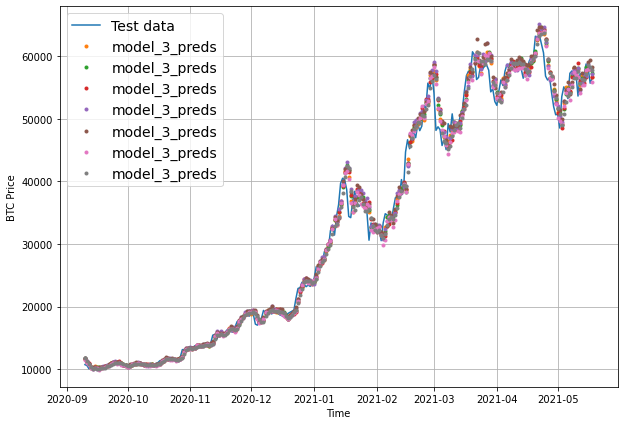

In [ ]:
OFFSET = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=OFFSET, label="Test data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_3_preds,  start=OFFSET, label="model_3_preds")

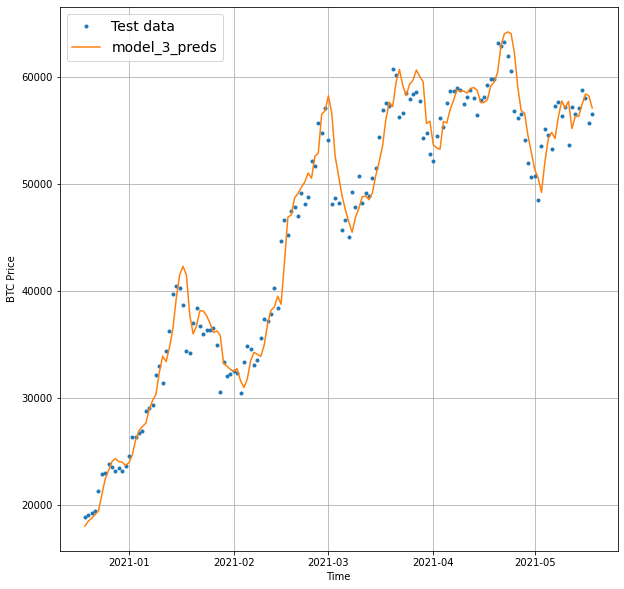

In [ ]:
# We need to reduce_mean first
OFFSET = 400
plt.figure(figsize=(10,10))
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=OFFSET, label="Test data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=OFFSET, format="-",  label="model_3_preds")

# Comparing between our models

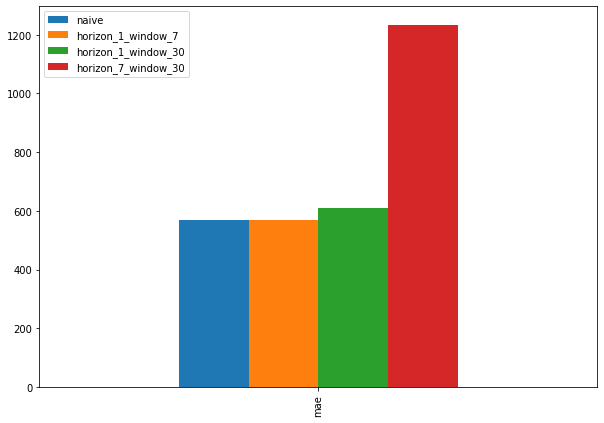

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
             "horizon_1_window_7": model_1_results["mae"],
             "horizon_1_window_30": model_2_results["mae"],
             "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10,7), kind="bar")

## Model 4: Conv1D

### Preparation to create Conv1D model

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, windows_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [ ]:
# Check data input shape
train_windows[0].shape

(7,)

In [ ]:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension
expand_dims_layer

In [ ]:
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expaned shape: {expand_dims_layer(x).shape}")
print(f"Original value with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expaned shape: (7, 1)
Original value with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


### Model creation

In [ ]:
# Create Conv1D model
model_4 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
                               layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile the model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(train_windows, train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Output shape is difference from model_2 so we need to change
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


### Make prediction and evaluate

In [ ]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 10ms/step - loss: 632.1914


632.19140625

In [ ]:
# Load in the best performing model
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 569.7348


569.7348022460938

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[0:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8909.537, 8810.121, 9011.64 , 8805.828, 8761.861, 8739.046,
       8705.329, 8556.901, 8471.023, 8535.135], dtype=float32)>

In [ ]:
# Evaluate prediction
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.73474,
 'mse': 1186286.1,
 'rmse': 1089.1676,
 'mape': 2.561848,
 'mase': 1.0008662}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mse': 1171744.0,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.99948955}

## Model 5: RNN(LSTM)

In [ ]:
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, return_sequences=True, activation="relu")(x)
# x = layers.LSTM(128, activation="relu")(x) # Swap with the upper function
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            validation_steps=int(0.01*len(test_windows)),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 2985.5625 

18/18 [==============================] - 3s 121ms/step - loss: 2886.9958 - val_loss: 15143.6641
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 1864.1625

18/18 [==============================] - 2s 123ms/step - loss: 1607.2931 - val_loss: 4022.4087
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 378.0234

18/18 [==============================] - 2s 107ms/step - loss: 354.6922 - val_loss: 1228.7788
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 245.3748

18/18 [==============================] - 2s 111ms/step - loss: 220.8634 - val_loss: 1136.3064
Epoch 5/100
14/18 [======================>.......] - ETA: 0s - loss: 200.4511

18/18 [==============================] - 2s 135ms/step - loss: 194.4907 - val_loss: 1053.5591
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 190.5184

18/18 [==============================] - 2s 126ms/step - loss: 194.3123 - val_loss: 1044.8445
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 190.5634 - val_loss: 1051.8990
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 181.2276

18/18 [==============================] - 2s 108ms/step - loss: 184.4326 - val_loss: 1043.8503
Epoch 9/100
12/18 [===================>..........] - ETA: 0s - loss: 184.3579

18/18 [==============================] - 2s 109ms/step - loss: 182.6488 - val_loss: 1039.9644
Epoch 10/100
10/18 [===============>..............] - ETA: 0s - loss: 175.8156

18/18 [==============================] - 2s 129ms/step - loss: 180.9793 - val_loss: 1022.2560
Epoch 11/100
11/18 [=================>............] - ETA: 0s - loss: 187.1548

18/18 [==============================] - 2s 111ms/step - loss: 180.0226 - val_loss: 1007.0238
Epoch 12/100
11/18 [=================>............] - ETA: 0s - loss: 182.7362

18/18 [==============================] - 2s 108ms/step - loss: 179.8048 - val_loss: 1000.2955
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 175.9432 - val_loss: 1008.2587
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 173.9792 - val_loss: 1019.7795
Epoch 15/100
11/18 [=================>............] - ETA: 0s - loss: 170.2615

18/18 [==============================] - 2s 126ms/step - loss: 173.5281 - val_loss: 971.1307
Epoch 16/100
11/18 [=================>............] - ETA: 0s - loss: 171.7611

18/18 [==============================] - 2s 110ms/step - loss: 170.5594 - val_loss: 950.6921
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 168.4101 - val_loss: 1027.9658
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 167.9052 - val_loss: 964.5699
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 163.9019 - val_loss: 961.4762
Epoch 20/100
11/18 [=================>............] - ETA: 0s - loss: 167.1394

18/18 [==============================] - 2s 109ms/step - loss: 163.7813 - val_loss: 904.4600
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 161.0188 - val_loss: 912.7787
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 158.7845 - val_loss: 906.0600
Epoch 23/100
11/18 [=================>............] - ETA: 0s - loss: 149.9673

18/18 [==============================] - 2s 108ms/step - loss: 155.8377 - val_loss: 902.8120
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 153.0210

18/18 [==============================] - 2s 130ms/step - loss: 154.4870 - val_loss: 877.8317
Epoch 25/100
11/18 [=================>............] - ETA: 0s - loss: 159.7988

18/18 [==============================] - 2s 108ms/step - loss: 152.0041 - val_loss: 857.6286
Epoch 26/100
11/18 [=================>............] - ETA: 0s - loss: 151.1246

18/18 [==============================] - 2s 110ms/step - loss: 151.3969 - val_loss: 829.0845
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 149.1276 - val_loss: 834.9641
Epoch 28/100
 9/18 [==============>...............] - ETA: 0s - loss: 159.1063

18/18 [==============================] - 3s 202ms/step - loss: 146.6709 - val_loss: 807.5612
Epoch 29/100
18/18 [==============================] - 0s 18ms/step - loss: 147.5251 - val_loss: 808.4918
Epoch 30/100
18/18 [==============================] - 0s 15ms/step - loss: 150.4298 - val_loss: 903.1788
Epoch 31/100
17/18 [===========================>..] - ETA: 0s - loss: 146.0783

18/18 [==============================] - 3s 193ms/step - loss: 145.8671 - val_loss: 779.4871
Epoch 32/100
18/18 [==============================] - 0s 11ms/step - loss: 139.2032 - val_loss: 793.3158
Epoch 33/100
10/18 [===============>..............] - ETA: 0s - loss: 140.2580

18/18 [==============================] - 3s 186ms/step - loss: 137.2109 - val_loss: 761.1064
Epoch 34/100
18/18 [==============================] - 0s 13ms/step - loss: 136.1992 - val_loss: 784.9362
Epoch 35/100
15/18 [========================>.....] - ETA: 0s - loss: 137.8194

18/18 [==============================] - 4s 219ms/step - loss: 135.2019 - val_loss: 741.9283
Epoch 36/100
18/18 [==============================] - 0s 14ms/step - loss: 135.2810 - val_loss: 744.7551
Epoch 37/100
17/18 [===========================>..] - ETA: 0s - loss: 131.2954

18/18 [==============================] - 2s 125ms/step - loss: 132.2451 - val_loss: 728.9268
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 139.4816

18/18 [==============================] - 2s 109ms/step - loss: 130.4677 - val_loss: 715.2835
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 130.5492 - val_loss: 755.6033
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 132.3941 - val_loss: 718.6049
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 129.2301 - val_loss: 723.7501
Epoch 42/100
12/18 [===================>..........] - ETA: 0s - loss: 127.2425

18/18 [==============================] - 2s 106ms/step - loss: 127.8628 - val_loss: 704.5550
Epoch 43/100
11/18 [=================>............] - ETA: 0s - loss: 120.2634

18/18 [==============================] - 2s 129ms/step - loss: 127.2031 - val_loss: 682.8713
Epoch 44/100
11/18 [=================>............] - ETA: 0s - loss: 121.4104

18/18 [==============================] - 2s 109ms/step - loss: 126.3174 - val_loss: 679.7807
Epoch 45/100
11/18 [=================>............] - ETA: 0s - loss: 123.2214

18/18 [==============================] - 2s 108ms/step - loss: 123.2601 - val_loss: 672.7501
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 130.4778

18/18 [==============================] - 2s 126ms/step - loss: 124.9882 - val_loss: 665.9292
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 123.8891 - val_loss: 714.0510
Epoch 48/100
18/18 [==============================] - 0s 7ms/step - loss: 122.8209 - val_loss: 692.7326
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 122.2332 - val_loss: 666.4348
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 128.6700 - val_loss: 678.2154
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 120.6429 - val_loss: 671.7126
Epoch 52/100
11/18 [=================>............] - ETA: 0s - loss: 128.2155

18/18 [==============================] - 2s 108ms/step - loss: 121.1700 - val_loss: 656.3633
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 120.4098 - val_loss: 658.8582
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 120.9058 - val_loss: 672.7007
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 124.4823

18/18 [==============================] - 2s 108ms/step - loss: 119.1008 - val_loss: 633.3700
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 121.4271 - val_loss: 699.7474
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 132.5774 - val_loss: 637.8978
Epoch 58/100
17/18 [===========================>..] - ETA: 0s - loss: 118.9064

18/18 [==============================] - 2s 108ms/step - loss: 118.9401 - val_loss: 627.6754
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 116.4679 - val_loss: 630.6281
Epoch 60/100
10/18 [===============>..............] - ETA: 0s - loss: 120.5395

18/18 [==============================] - 2s 130ms/step - loss: 117.5672 - val_loss: 623.7516
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 116.1612 - val_loss: 632.5638
Epoch 62/100
12/18 [===================>..........] - ETA: 0s - loss: 114.1972

18/18 [==============================] - 2s 108ms/step - loss: 115.5905 - val_loss: 620.3993
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 117.0712 - val_loss: 626.2255
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 117.0453 - val_loss: 713.6877
Epoch 65/100
18/18 [==============================] - 0s 7ms/step - loss: 121.5329 - val_loss: 675.8682
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 116.3974 - val_loss: 657.0650
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 117.3636 - val_loss: 641.1585
Epoch 68/100
18/18 [==============================] - 0s 8ms/step - loss: 120.0278 - val_loss: 643.5811
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 125.8248 - val_loss: 659.2689
Epoch 70/100
18/18 [==============================] - ETA: 0s - loss: 119.7580

18/18 [==============================] - 2s 109ms/step - loss: 119.7580 - val_loss: 619.5898
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 114.4593 - val_loss: 624.5800
Epoch 72/100
11/18 [=================>............] - ETA: 0s - loss: 116.8068

18/18 [==============================] - 2s 126ms/step - loss: 115.5041 - val_loss: 613.7982
Epoch 73/100
12/18 [===================>..........] - ETA: 0s - loss: 113.0147

18/18 [==============================] - 2s 115ms/step - loss: 112.7576 - val_loss: 612.2810
Epoch 74/100
11/18 [=================>............] - ETA: 0s - loss: 114.7751

18/18 [==============================] - 2s 109ms/step - loss: 113.7394 - val_loss: 603.4439
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 112.8682 - val_loss: 609.4792
Epoch 76/100
18/18 [==============================] - 0s 8ms/step - loss: 112.9054 - val_loss: 605.5240
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 115.1632 - val_loss: 648.4973
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 114.5188 - val_loss: 605.0037
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3178 - val_loss: 612.8160
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6201 - val_loss: 619.4008
Epoch 81/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2624 - val_loss: 627.6325
Epoch 82/100
11/18 [=================>............] - ETA: 0s - loss: 122.7047

18/18 [==============================] - 2s 126ms/step - loss: 115.5610 - val_loss: 595.0139
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 113.3720 - val_loss: 617.6613
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 114.3010 - val_loss: 595.7070
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2715 - val_loss: 602.9136
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2969 - val_loss: 632.5641
Epoch 87/100
11/18 [=================>............] - ETA: 0s - loss: 118.4282

18/18 [==============================] - 2s 112ms/step - loss: 114.3313 - val_loss: 591.1862
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 113.6463 - val_loss: 591.2580
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 116.0857 - val_loss: 607.1873
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 114.3215 - val_loss: 749.0079
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 116.2251 - val_loss: 593.4322
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7677 - val_loss: 591.4593
Epoch 93/100
18/18 [==============================] - 0s 8ms/step - loss: 113.2648 - val_loss: 628.7288
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 111.7268 - val_loss: 607.4488
Epoch 95/100
11/18 [=================>............] - ETA: 0s - loss: 105.7588

18/18 [==============================] - 2s 110ms/step - loss: 110.7704 - val_loss: 587.0773
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 112.5763 - val_loss: 590.4714
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 112.0440 - val_loss: 628.4246
Epoch 98/100
11/18 [=================>............] - ETA: 0s - loss: 110.4344

18/18 [==============================] - 2s 109ms/step - loss: 109.7727 - val_loss: 582.1003
Epoch 99/100
18/18 [==============================] - 0s 7ms/step - loss: 109.7509 - val_loss: 587.1587
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.6825 - val_loss: 640.9327


In [ ]:
# Load the best model version
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 582.1003


582.1002807617188

In [ ]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8937.026, 8821.751, 8980.77 , 8786.303, 8762.457], dtype=float32)>

In [ ]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 582.10034,
 'mse': 1220680.2,
 'rmse': 1104.844,
 'mape': 2.6447268,
 'mase': 1.0225891}

# Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

Maybe the bitcoin halving events? Then Let's make a multivariate time series

In [ ]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Let's add a bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset
block_reward_2 = 25 # November 2012
block_reward_3 = 12.5 # July 2016
block_reward_4 = 6.25 # May 2020

# block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date range of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,None
2013-10-02,125.45500,None
2013-10-03,108.58483,None
2013-10-04,118.67466,None
2013-10-05,121.33866,None


In [ ]:
# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[0:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

The plot need to be scale if it's not the plot will means nothing

In [ ]:
# # Just for testing
# bitcoin_prices_block.plot(figsize=(10,10))

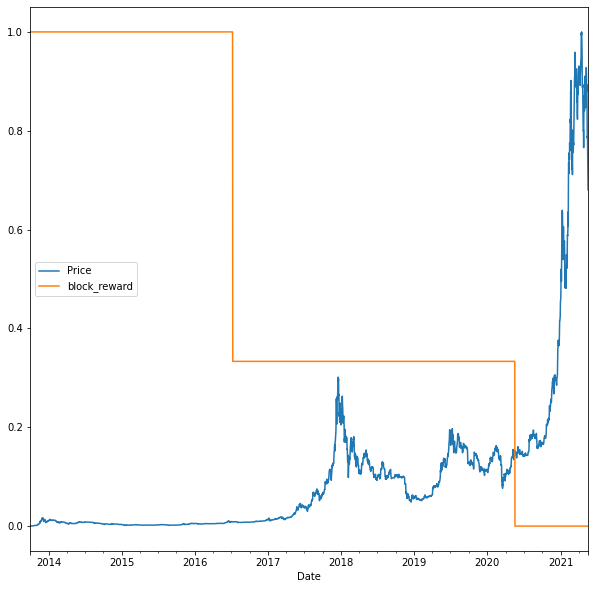

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,10))

## Making a windowed dataset winth pandas

Previously, we've turned our univariate time eseries into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is create a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[ 1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
# Create X (windows) and y (horizons) features
x = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [ ]:
x.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train an test sets using indexing
split_size = int(len(x)*0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]

len(x_train), len(y_train), len(x_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [ ]:
# Make multivariate time series model
model_1.summary() # compare base with model 1

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Make multivariate time series model
model_6 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
model_6.fit(x_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 [==============================] - 1s 38ms/step - loss: 1537.3694 - val_loss: 1653.0455
Epoch 2/100
18/18 [==============================] - 1s 29ms/step - loss: 308.1770 - val_loss: 1170.8402
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 221.3277 - val_loss: 1443.8743
Epoch 4/100
18/18 [==============================] - 1s 31ms/step - loss: 190.1277 - val_loss: 1000.3667
Epoch 5/100
18/18 [==============================] - 1s 40ms/step - loss: 163.6042 - val_loss: 877.7004
Epoch 6/100
18/18 [==============================] - 1s 53ms/step - loss: 144.3452 - val_loss: 742.4996
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 131.2487 - val_loss: 789.8508
Epoch 8/100
18/18 [==============================] - 1s 29ms/step - loss: 122.9365 - val_loss: 642.2186
Epoch 9/100
18/18 [==============================] - 1s 45ms/step - loss: 119.8044 - val_loss: 614.2115
Epoch 10/100
18/18 [==============================] - 0s 5ms/

### Make prediction and evaluate

In [ ]:
# Evaluate the model
model_6.evaluate(x_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 580.8610


580.8610229492188

In [ ]:
# Load the best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(x_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 560.8261


560.8261108398438

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(x_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8791.969 , 8754.409 , 9002.3545, 8737.593 , 8746.372 , 8680.023 ,
       8642.798 , 8517.572 , 8411.618 , 8506.001 ], dtype=float32)>

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 560.8261,
 'mse': 1137040.6,
 'rmse': 1066.321,
 'mape': 2.5252554,
 'mase': 0.98521614}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mse': 1171744.0,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## ❌Course Content 330 - 331 
Tensorflow Cetrtificate

## Model 7: N-BEATS Preparation

Let's try build the biggest time series forecasting model we've built sofar.

More specifically, we're going to be replicating the algorithm in the following paper (figure 1): https://arxiv.org/pdf/1905.10437.pdf

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results on our problem

Custom layers and models: https://www.tensorflow.org/tutorials/customization/custom_layers



### Create NBeatsBlock class

In [ ]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connect layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu", name=f"hidden_{1}") for i in range(n_layers)] # Create the hidden layers by number of n_layers

    # Output of block is a theta layer
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


### Test NBeatsBlock class with Dummy

Make some dummy inputs and outputs

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4) # backcast + forecast

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) +1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.15632057  0.37564403 -0.32300907  0.23842326  0.2613251  -0.68667954
 -0.31051293]
Forecast: 0.1570146381855011


## Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible, we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create N-BATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels
x = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# # Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [ ]:
i=0
for element in train_dataset.as_numpy_iterator():
  if i<5:
    print(element)
    print("======")
  else:
    break
  i += 1

(array([[121.795  , 120.65533, 121.33866, ..., 108.58483, 125.455  ,
        123.65499],
       [123.033  , 121.795  , 120.65533, ..., 118.67466, 108.58483,
        125.455  ],
       [124.049  , 123.033  , 121.795  , ..., 121.33866, 118.67466,
        108.58483],
       ...,
       [654.895  , 654.725  , 666.747  , ..., 673.008  , 673.832  ,
        681.239  ],
       [660.284  , 654.895  , 654.725  , ..., 662.034  , 673.008  ,
        673.832  ],
       [655.418  , 660.284  , 654.895  , ..., 666.747  , 662.034  ,
        673.008  ]]), array([123.033  , 124.049  , 125.96116, ..., 660.284  , 655.418  ,
       650.82899]))
(array([[ 650.82899   ,  655.418     ,  660.284     , ...,  654.725     ,
         666.747     ,  662.034     ],
       [ 656.91599   ,  650.82899   ,  655.418     , ...,  654.895     ,
         654.725     ,  666.747     ],
       [ 655.427     ,  656.91599   ,  650.82899   , ...,  660.284     ,
         654.895     ,  654.725     ],
       ...,
       [7906.94083505

## Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residuals network
Before we can craft our N-Beats model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS Paper).

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

In [ ]:
# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1} & {tensor_2}")
print(f"Subtracted output: {subtracted}")
print(f"Added output: {added}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted output: [10 10 10 10 10 10 10 10 10 10]
Added output: [10 12 14 16 18 20 22 24 26 28]


### Building and compliling

1. Setting an instance of the N-Beats block layer using `NBeatsBlock` (this'll be initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts.
6.  Create the double residual stacking using substract and add layers.
7. Put the model inputs and outputs togeter using 1tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of the n-beats paper.
9. Fit the N-Beats model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  - Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  - Reduce LR on Plateau - if a model stops imnproving, try lowering the learning to reduce the amount it updates, try weights each time (take smaller steps towards the best performance)

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name="InitialBlock")

# 2. Create an input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is aready created in (3)


  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecsat
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

    # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                        patience=200, 
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 863: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1151: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1251: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3min 25s, sys: 7.48 s, total: 3min 32s
Wall time: 3min 42s


In [ ]:
# Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 573.2089


573.2088623046875

In [ ]:
# Make predictions with N-Beats model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8847.429, 8786.356, 9022.792, 8755.824, 8754.105, 8739.899,
       8656.944, 8503.   , 8473.151, 8509.623], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 573.20886,
 'mse': 1166074.2,
 'rmse': 1079.8491,
 'mape': 2.5729723,
 'mase': 1.0069692}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mse': 1171744.0,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.99948955}

### Plotting N-Beats architecture

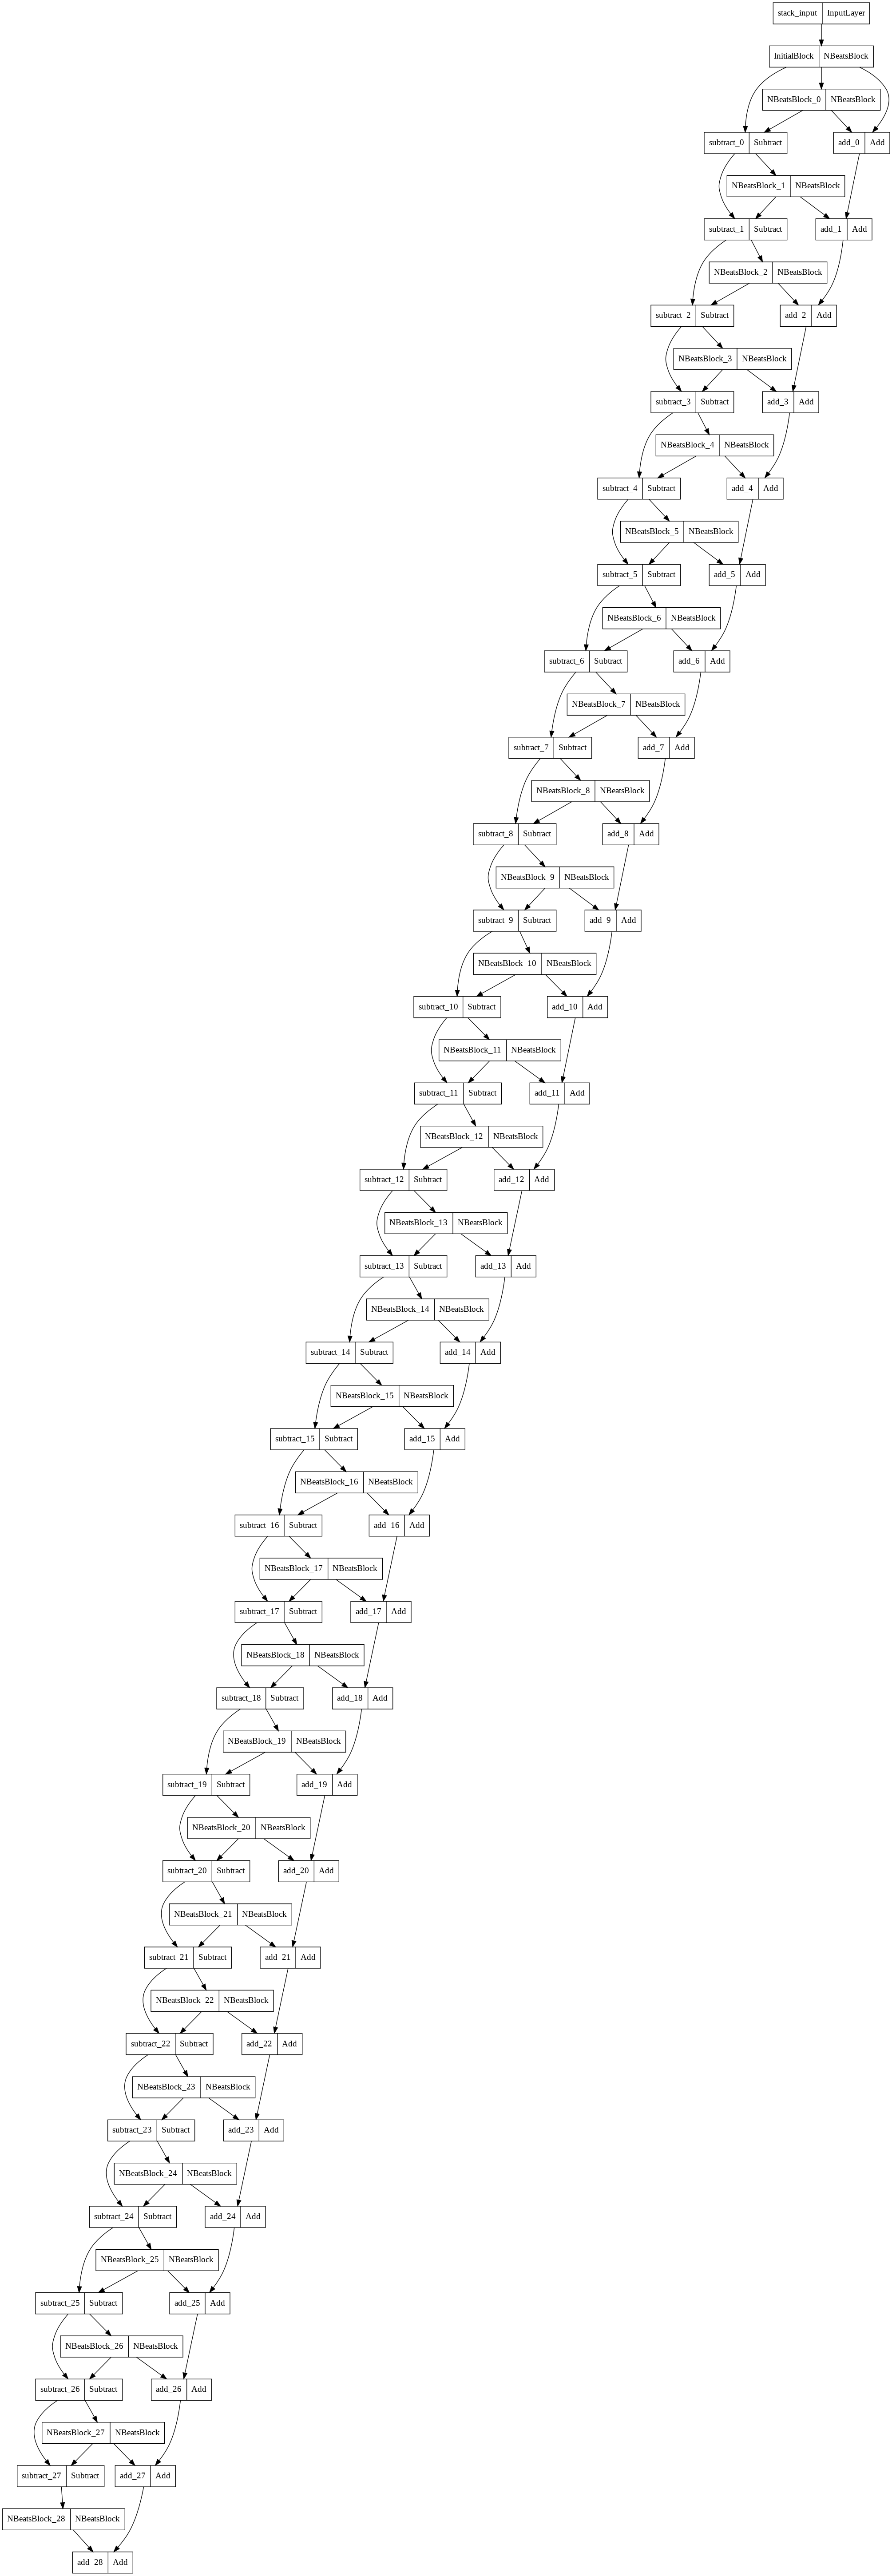

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom the crowd effect.

It combines many *different* models to predict a common goal.

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting and ensemble of model

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae","mse","mape"]):
  """
  Returns a list of num_item models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae","mse","mape"]).
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_item number of models pe loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model_number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimation prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse"])
      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to a list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

    

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model_number: 0

Epoch 688: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 992: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model_number: 0

Epoch 626: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 742: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 842: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model_number: 0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model_number: 1

Epoch 979: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model_number: 1

Epoch 428: ReduceLROnPl

### Make prediction with ensemble model

In [ ]:
ensemble_models

In [ ]:
# Create a function which uses a list of trained models to make and return a list of prediction
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds =  []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))


In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models,
                                     data=test_dataset)


ensemble_preds

CPU times: user 1.07 s, sys: 38.1 ms, total: 1.11 s
Wall time: 1.37 s


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8791.244,  8765.13 ,  9019.184, ..., 50061.43 , 49111.355,
        46396.434],
       [ 8766.692,  8744.137,  9056.013, ..., 49395.516, 48514.562,
        45347.754],
       [ 8745.423,  8733.032,  9101.387, ..., 49267.17 , 47660.42 ,
        45370.055],
       ...,
       [ 8940.605,  8796.099,  9074.6  , ..., 49838.24 , 49643.71 ,
        46642.41 ],
       [ 8725.244,  8801.676,  9100.441, ..., 49574.113, 48514.297,
        45028.74 ],
       [ 8817.612,  8761.644,  9040.957, ..., 49727.504, 48055.766,
        45830.637]], dtype=float32)>

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)

ensemble_results

{'mae': 578.3045,
 'mse': 1178916.9,
 'rmse': 1085.599,
 'mape': 2.645754,
 'mase': 1.0159209}

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[0:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8791.532, 8776.2  , 9066.604, 8734.264, 8744.943, 8717.671,
       8668.149, 8480.968, 8459.853, 8529.387], dtype=float32)>

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8778.978 , 8776.934 , 9071.512 , 8719.593 , 8750.433 , 8725.017 ,
       8669.405 , 8478.889 , 8456.5625, 8531.971 ], dtype=float32)

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 566.3034,
 'mse': 1144568.5,
 'rmse': 1069.8451,
 'mape': 2.5769286,
 'mase': 0.99483824}

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 567.96643,
 'mse': 1150790.5,
 'rmse': 1072.749,
 'mape': 2.5789673,
 'mase': 0.9977597}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mse': 1171744.0,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.99948955}

### Plotting the prediction intervals (uncertainly estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where the prediction came from?

Instead of 50,000 USD on the. dot, how about 48,000 to 52,000 USD?

One way to geyt the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of random initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiplt the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal Distribition, 95% of observations fall within 1.96 standard deviations of the mean)
4. To get the prediction interval upper and lower bounds, add ann subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [ ]:
# Test reduce_std
tf.math.reduce_mean(ensemble_preds, axis=0)

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8791.532 ,  8776.2   ,  9066.604 ,  8734.264 ,  8744.943 ,
        8717.671 ,  8668.149 ,  8480.968 ,  8459.853 ,  8529.387 ,
        8204.067 ,  8106.066 ,  8050.1006,  7624.56  ,  7267.9736,
        7298.2295,  7079.855 ,  7208.059 ,  7112.5947,  7541.503 ,
        7376.222 ,  7750.6377,  7557.817 ,  7394.7065,  7322.7173,
        7315.5757,  7208.3433,  7394.2866,  7508.9814,  7538.6606,
        7540.722 ,  7328.6846,  7231.536 ,  7180.669 ,  7191.5127,
        7236.236 ,  7084.5034,  7105.584 ,  6870.538 ,  6586.249 ,
        7402.7275,  7173.659 ,  7172.435 ,  7254.6997,  7273.8677,
        7194.3384,  7218.898 ,  7209.9604,  7179.8936,  7214.059 ,
        7306.892 ,  7383.8296,  7244.9126,  7169.524 ,  7160.5747,
        6952.139 ,  7280.0713,  7333.237 ,  7366.5503,  7707.546 ,
        8068.1   ,  8129.6953,  7852.964 ,  8093.209 ,  8095.8325,
        8173.044 ,  8093.409 ,  8749.464 ,  8889.764 ,  8769.374 ,
        8938.8

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds):  # 1. Take the predictions from a number of randomly initialized

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96*std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower[0:10], upper[0:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8695.516, 8731.987, 9009.31 , 8634.594, 8681.271, 8661.713,
        8601.817, 8406.204, 8408.295, 8494.98 ], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8887.549, 8820.413, 9123.897, 8833.934, 8808.615, 8773.629,
        8734.481, 8555.731, 8511.41 , 8563.793], dtype=float32)>)

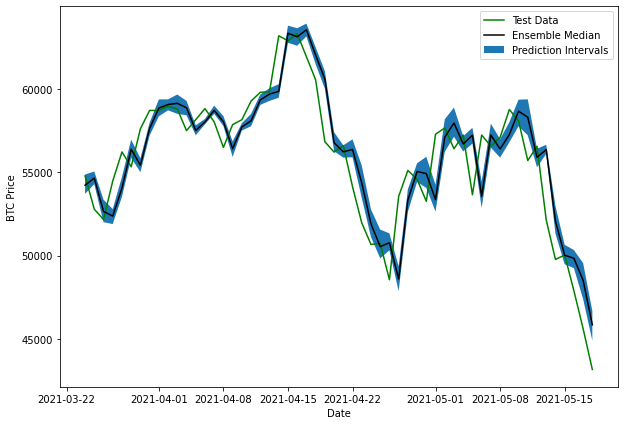

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals
offset = 500
plt.figure(figsize=(10,7))
plt.plot(x_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(x_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(x_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend()
plt.show()

All of our data models predictions have been lagging behind the test data...

As is they're replicating what the naive model does and just predict  the previous timestelp as the next timestep.

> 🔑 **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Aside: two types of encertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitavely answer the questions:
1. What can my model know? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know? (what can a model never predict? Or would it helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as "data" uncertainty or "subway uncertainty"
  - Cannot be reduced with more data - When measuring prediction intervals, we're estimating a form of aleatoric uncertainty.
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut uncertainty"
  - Can be reduced with more data

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofutre.

Let's now build a model which is capable of predicting into future!

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [ ]:
# Train model on entire data to make predictions for the next day
x_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()

# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()
y_all

array([  123.033     ,   124.049     ,   125.96116   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

In [ ]:
len(x_all) ,len(y_all)

(2780, 2780)

In [ ]:
x_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [ ]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(x_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=['mae'],
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)
            # callbacks=[create_model_checkpoint(model_name=model_9.name)])

### Make predictions into future


In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:
1. Takes as input:
* a list of values (Bitcoin historical data)
* a trained model (such as `model_9`)
* a window into the future to predict (our `INTO_FUTURE` variable)
* the window size of a. model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on

2. Creates an empty list for future forecasts (this will be returned at the end of the function, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values.

3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the last prediction.

In [ ]:
tf.expand_dims(y_all[-WINDOW_SIZE:], axis=0)

<tf.Tensor: shape=(1, 7), dtype=float64, numpy=
array([[56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361, 43144.47129086]])>

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make the future forecasts into_future steps after values ends.
  
  Return future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again and again (our model will eventually start to make forecast on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

Predicting on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.46484375

Predicting on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.46484375] -> Prediction: 50985.9453125

Predicting on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.46484375 50985.9453125 ] -> Prediction: 48522.96875

Predicting on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.46484375 50985.9453125  48522.96875   ] -> Prediction: 48137.203125

Predicting on:
 [47885.62525472 45604.61575361 43144.47129086 55764.46484375
 50985.9453125  48522.96875    48137.203125  ] -> Prediction: 47880.6328125

Predicting on:
 [45604.61575361 43144.47129086 55764.46484375 50985.9453125
 48522.96875    48137.203125   47880.6328125 ] -> Prediction: 46879.71484375

Predicting on:
 [43144.47129086 55764.46484375 50985.9453125  48522.96875
 481

### Visualize future forecasts

In [ ]:
future_forecast

[55764.465,
 50985.945,
 48522.97,
 48137.203,
 47880.633,
 46879.715,
 48227.598,
 53963.69,
 49685.56,
 47596.176,
 48114.426,
 48808.004,
 48623.848,
 50178.723]

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datatime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # Specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # Specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # Return a date range betwee start and end date

In [ ]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep, type(last_timestep)

(Timestamp('2021-05-18 00:00:00'), pandas._libs.tslibs.timestamps.Timestamp)

In [ ]:
# Get net two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55764.465, 50985.945, 48522.97 , 48137.203, 47880.633,
        46879.715, 48227.598, 53963.69 , 49685.56 , 47596.176, 48114.426,
        48808.004, 48623.848, 50178.723], dtype=float32))

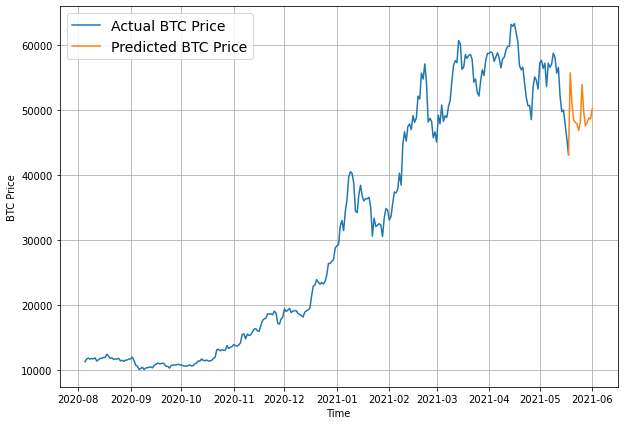

In [ ]:
# Plot the future prices predictions of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem)